**TP Filtres de Kalman d'ensemble**

L'objectif de ce TP est la mise en place d'un système d'assimilation de données par filtres de Kalman d'ensemble, pour le système de Lorenz 63 :

$$ \dot{x} = \sigma (y-x) $$
$$ \dot{y} = x (\rho -z ) -y $$
$$ \dot{z} = xy -\beta z $$
Les paramètres par défaut sont $\sigma = 10$, $\rho = 28$, $\beta=8/3$, et la condition initiale $(1.5, -1.5, 21)$. 

*Sources*: ce TP s'inspire des notebooks d'E. Cosme (UGA).


In [1]:
import numpy as np
import math
import scipy as scp
import scipy.sparse as scps
import scipy.sparse.linalg as sla
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#-------------------------------------------------------
# Lorenz 63
#-------------------------------------------------------

class Model:

    def __init__( self, nmembers = 1 ):
        self.nmembers = nmembers
        self.nx = 3                     
        self.sigma = 10.
        self.rho = 28.
        self.beta = 8./3.
        self.dt = 0.01
        self.x0 = np.array([1.5, -1.5, 20.])
        self.xvar = self.initial_condition() 
        self.xvar_series = []
        self.time = 0.
        self.time_series = []
        
    def initial_condition(self):
        """Condition initiale"""
        if self.nmembers == 1:
            xout = self.x0.reshape((self.nx, 1))
        else:
            p0 = 3.*np.eye(self.nx)
            xout = np.random.multivariate_normal(self.x0, p0, self.nmembers).T
        return xout

    def rhs(self,x_in):
        """Second membre"""
        x_out=np.zeros_like(x_in)
        x_out[0,]=self.sigma*(x_in[1,]-x_in[0,])
        x_out[1,]=self.rho*x_in[0,]-x_in[1,]-x_in[0,]*x_in[2,]
        x_out[2,]=x_in[0,]*x_in[1,]-self.beta*x_in[2,]
        return x_out

    def forward(self, nstep_in):
        """Intégration temporelle"""
        self.xvar_series = np.zeros((self.nx, nstep_in, self.nmembers))
        self.time_series = np.zeros(nstep_in)
        for it in range(nstep_in):
            self.xvar_series[:,it,:] = self.xvar
            self.time_series[it] = self.time
            k1=self.rhs(self.xvar)*self.dt
            xtmp=self.xvar+0.5*k1
            k2=self.rhs(xtmp)*self.dt
            xtmp=self.xvar+0.5*k2
            k3=self.rhs(xtmp)*self.dt
            xtmp=self.xvar+k2
            k4=self.rhs(xtmp)*self.dt
            self.xvar+=(k1+2*k2+2*k3+k4)/6.
            self.time += self.dt
  
    def plot(self):
        """Affichage"""
        plt.figure(figsize=(12,8))
        for ix in range(self.nx):
            pnum = 311+ix
            plt.subplot(pnum)
            for ie in range(self.nmembers):
                plt.plot(self.time_series[:],self.xvar_series[ix,:,ie],'black',linewidth=1.)
        plt.show()

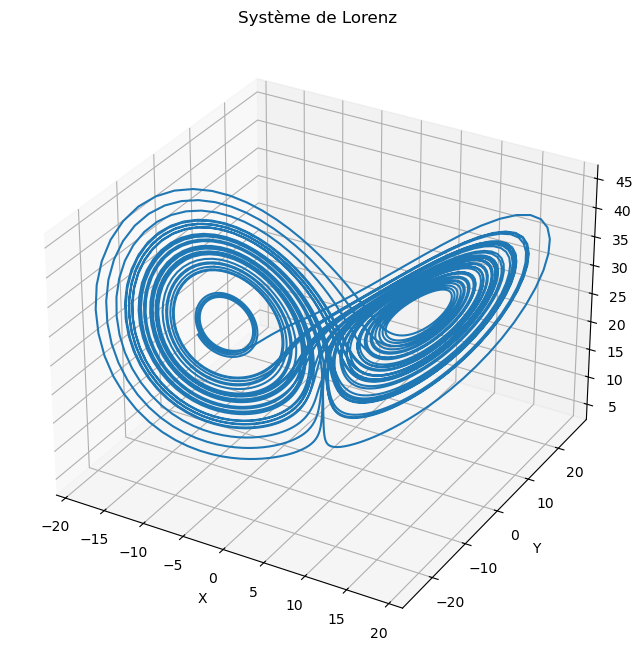

In [3]:
# Illustration du système de Lorenz 63 #

lorenz_test = Model()
lorenz_test.forward(5000)
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(projection='3d')
ax.plot(lorenz_test.xvar_series[0,:,0], lorenz_test.xvar_series[1,:,0], lorenz_test.xvar_series[2,:,0])
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.set_title("Système de Lorenz")
plt.show()

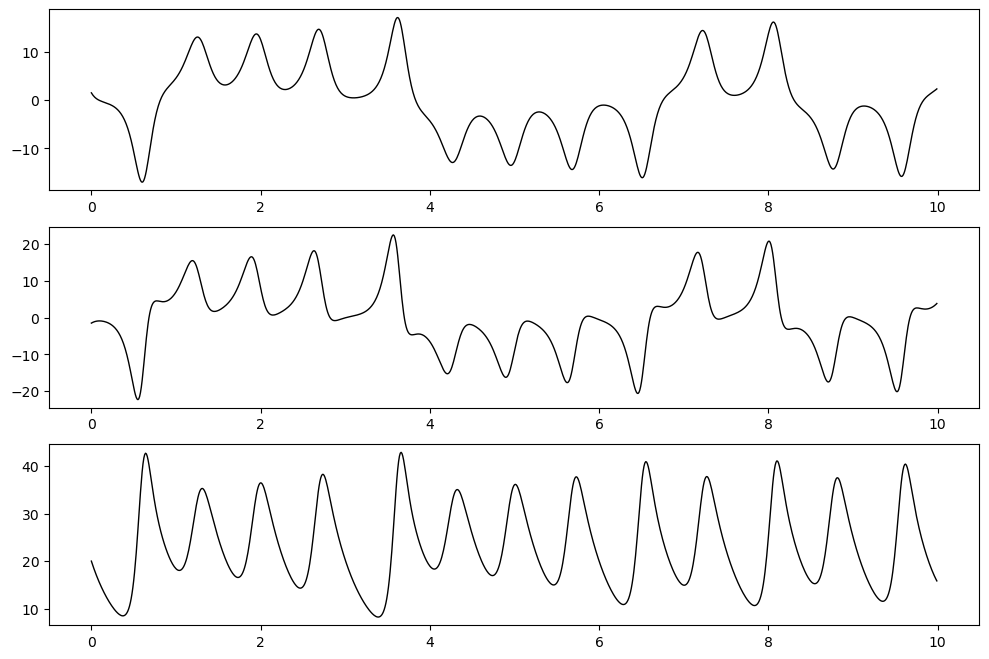

In [4]:
# Simulation de référence
ntime=1000
lorenz_ref = Model()
lorenz_ref.forward(ntime)
lorenz_ref.plot()
true_state = lorenz_ref.xvar_series
true_time = lorenz_ref.time_series

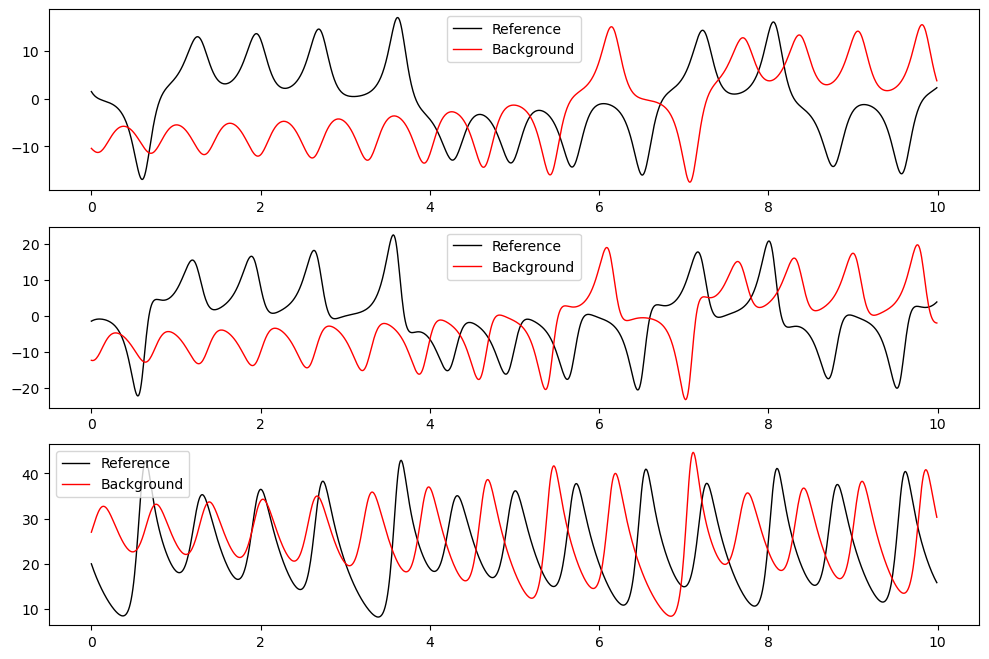

In [5]:
# Ebauche : erreur sur l'état initial et le paramètre rho
background_state = np.array([0.5, -3., 22.])
lorenz_bkg = Model()
lorenz_bkg.rho = 29.
lorenz_bkg.x0 = np.copy(background_state)
lorenz_bkg.xvar = lorenz_test.initial_condition()
lorenz_bkg.forward(ntime)
plt.figure(figsize=(12,8))
for ix in range(3):
    pnum = 311+ix
    plt.subplot(pnum)
    plt.plot(true_time,true_state[ix,:,0],'black',linewidth=1.,label='Reference')
    plt.plot(lorenz_bkg.time_series,lorenz_bkg.xvar_series[ix,:,0],'red',linewidth=1.,label='Background')
    plt.legend()
plt.show()

In [6]:
# Configuration des observations 
nvarobs = [0,2]
nobs = len(nvarobs)
H=np.zeros((nobs,3))
H[0,0]=1.
H[1,2]=1.
assim_steps = range(25,ntime,50)
nassim = len(assim_steps)
lencycle = np.hstack((assim_steps[0], np.ediff1d(assim_steps)))
so2=9.e-2
Robs = so2*np.eye(nobs)

**Analyse par EnKF/ETKF**


On note ${\bf E}^f\in \mathbb{R}^{m\times n}$ l'ensemble de prévision, $\bar{\bf x}^f=\frac{1}{n}{\bf E}^f{\bf e}\in \mathbb{R}^{m}$ sa moyenne, et ${\bf A}^f={\bf E}^f({\bf I}_n-\frac{1}{n}{\bf  e}{\bf  e}^T)\in \mathbb{R}^{m\times n}$, la matrice d'anomalies, avec ${\bf  e}=[1,\dots,1]^T$. 

On souhaite réaliser l'étape d'analyse du filtre de Kalman d'ensemble (EnKF), et de sa variante déterministe (ETKF). Ces deux analyses se décomposent en deux étapes :

1- Mise à jour de la moyenne de l'ensemble :
$$
    \bar{\bf x}^a=\bar{\bf x}^f+ {{\bf A}^f{\bf G}}{\bf R}^{-\frac{1}{2}}({\bf y}-{\bf H}\bar{\bf x}^f)/\sqrt{n-1},
$$

avec ${\bf y}$ le vecteur d'observations, ${\bf H}$ l'opérateur d'observation,
${\bf G}={{\bf S}^T}({\bf I}_p+{{\bf S}}{{\bf S}^T})^{-1}$,
et ${\bf S}={\bf R}^{-\frac{1}{2}}{\bf H}{{\bf A}^f}/\sqrt{n-1}$.


2- Mise à jour de la matrice d'anomalies :
$$
{\bf A}^a={\bf A}^f+ {\bf A}^f {\bf T},
$$
avec ${\bf T}$ définie par :

     a- EnKF :
$${\bf T}={\bf G}({\bf D}-{\bf S}),$$ avec  ${\bf D}={\bf R}^{-\frac{1}{2}}\tilde{\bf D}/\sqrt{n-1}$, $\tilde{\bf D}$ perturbations gaussiennes telles que $\tilde{\bf D}{\bf e}=0$, et $\tilde{\bf D}\tilde{\bf D}^T/(n-1)\rightarrow {\bf R}$.
     
     b- ETKF : 
$${\bf T}=({\bf I}_n+{\bf S}^T{\bf S})^{-\frac{1}{2}}-{\bf I}_n.$$


L'ensemble d'analyse est alors obtenu par $${\bf E}^a={\bf x}^a{\bf e}^T+{\bf A}^a.$$

Plus d'information dans Sakov et al. (2010). 


In [7]:
# Analyse par EnKF ou ETKF #
import scipy
def analysis(Ef ,y,Robs,H,methode,moderation):
    # Paramètres d'entrée :
    # Ef : ensemble de prévision
    # y : vecteur d'observations
    # Robs : matrice de covariance d'erreur d'observation
    # H : operateur d'observation
    # methode : 1 ETKF, sinon EnKF
    # moderation : paramètres de modération
    #################################
    # Sortie : 
    # Ea : ensemble d'analyse
    Ea=np.zeros_like(Ef)
    
    ### TO DO ###
    m = Ef.shape[0] #3
    n = Ef.shape[1] # nmem
    p = len(y)
    e = np.ones(n)
    x_mean_f = (Ef@e)/n
    A_f = Ef@(np.identity(n) - (e@e.T)/n)
    S = (scipy.linalg.inv(scipy.linalg.sqrtm(Robs))@H@A_f)/np.sqrt(n-1)
    G = (S.T)@np.linalg.inv((np.identity(p) + S@S.T))
    # test = A_f@G@np.linalg.inv(Robs@Robs)@(np.hstack(y) - H@x_mean_f)/np.sqrt(n-1)
    x_mean_a = x_mean_f + A_f@G@scipy.linalg.inv(scipy.linalg.sqrtm(Robs))@(np.hstack(y) - H@x_mean_f)/np.sqrt(n-1)
    

    if methode == 1: #ETFK
        T = scipy.linalg.inv(scipy.linalg.sqrtm((np.identity(n) + (S.T)@S))) - np.identity(n)
    else: #EnKF
        D_tilde = np.random.multivariate_normal(mean=np.zeros(p), cov=Robs, size=n).T
        D = scipy.linalg.inv(scipy.linalg.sqrtm(Robs))@D_tilde/np.sqrt(n-1)
        T = G@(D - S)
        
    A_a = A_f + A_f@T
    Ea = np.outer(x_mean_a,e.T) + A_a
    
    ### END TO DO
    
    return Ea

changer formule on a forcé l'erreur d'obs a être plus forte pour avoir des corrections plus faibles donc prends plus de temps à corriger

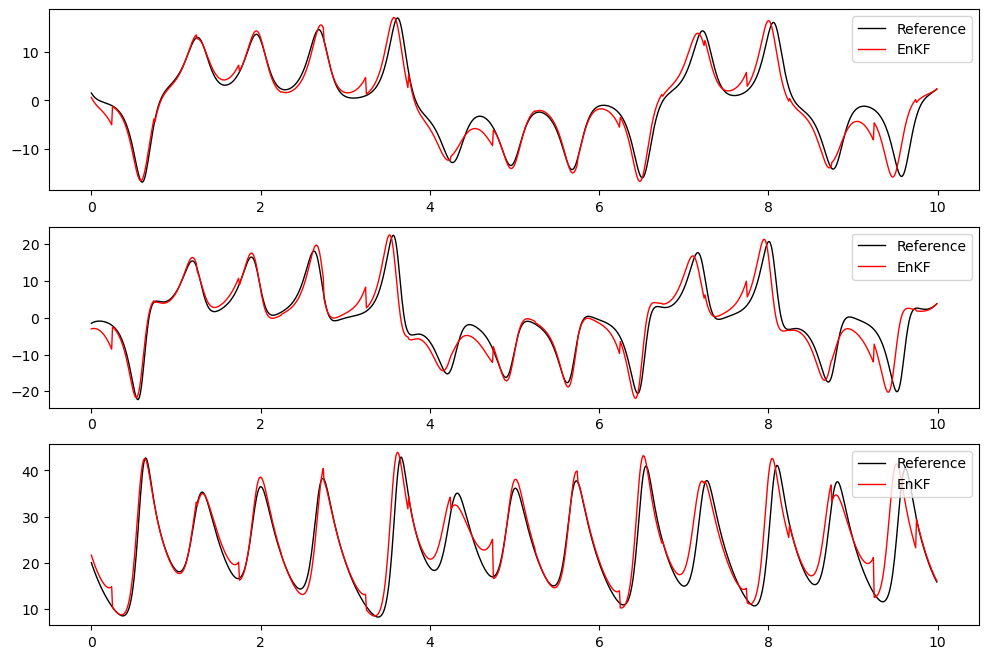

In [12]:
#Cycle d'assimilation par filtres de Kalman d'ensemble
nmem=30 #nb de simulation qu'on va faire
lorenz_assim = Model(nmembers=nmem)
lorenz_assim.x0 = np.copy(background_state)
lorenz_assim.xvar = lorenz_assim.initial_condition()
lorenz_assim.rho = 29.
do_assim=1

time1 = np.empty(ntime)
xvar1 = np.empty((3, ntime, nmem))

for ic in range(nassim):
    
    ## Forecast
    if ic == 0:
        nstep = assim_steps[0]
    else:
        nstep = assim_steps[ic] - assim_steps[ic-1]
        
    lorenz_assim.forward(nstep)
    
    if ic == 0:
        time1 = lorenz_assim.time_series
        xvar1 = lorenz_assim.xvar_series
    else:
        time1 = np.hstack(( time1, lorenz_assim.time_series ))
        xvar1 = np.concatenate( ( xvar1, lorenz_assim.xvar_series ), axis = 1 )
    
    ## Analysis
    obs_index = np.argwhere( true_time == lorenz_assim.time )
    y=np.transpose(true_state[nvarobs, obs_index, 0] +np.dot(math.sqrt(so2)*np.eye(nobs),np.random.normal(0,1,(nobs,))))
    if(do_assim==1):
        lorenz_assim.xvar =analysis(lorenz_assim.xvar,y,Robs,H,0,[])

    
## Last cycle
lorenz_assim.forward( ntime - assim_steps[-1] )
time1 = np.hstack(( time1, lorenz_assim.time_series ))
xvar1 = np.concatenate( ( xvar1, lorenz_assim.xvar_series ), axis = 1 )

## Plots

xvarmean = np.mean(xvar1, axis=2)

plt.figure(figsize=(12,8))
for ix in range(3):
    pnum = 311+ix
    plt.subplot(pnum)
    plt.plot(true_time,true_state[ix,:,0],'black',linewidth=1.,label='Reference')
    plt.plot(time1, xvarmean[ix,:],'red',linewidth=1.,label='EnKF')
    plt.legend()

plt.show()

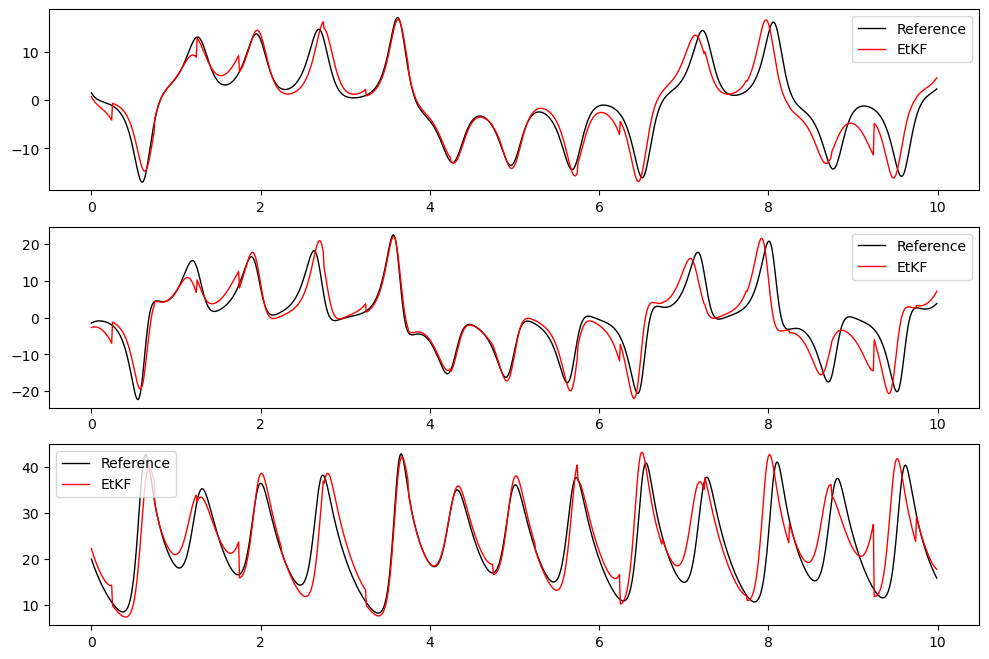

In [13]:
#Cycle d'assimilation par filtres de Kalman d'ensemble
nmem=30 #nb de simulation qu'on va faire
lorenz_assim = Model(nmembers=nmem)
lorenz_assim.x0 = np.copy(background_state)
lorenz_assim.xvar = lorenz_assim.initial_condition()
lorenz_assim.rho = 29.
do_assim=1

time1 = np.empty(ntime)
xvar1 = np.empty((3, ntime, nmem))

for ic in range(nassim):
    
    ## Forecast
    if ic == 0:
        nstep = assim_steps[0]
    else:
        nstep = assim_steps[ic] - assim_steps[ic-1]
        
    lorenz_assim.forward(nstep)
    
    if ic == 0:
        time1 = lorenz_assim.time_series
        xvar1 = lorenz_assim.xvar_series
    else:
        time1 = np.hstack(( time1, lorenz_assim.time_series ))
        xvar1 = np.concatenate( ( xvar1, lorenz_assim.xvar_series ), axis = 1 )
    
    ## Analysis
    obs_index = np.argwhere( true_time == lorenz_assim.time )
    y=np.transpose(true_state[nvarobs, obs_index, 0] +np.dot(math.sqrt(so2)*np.eye(nobs),np.random.normal(0,1,(nobs,))))
    if(do_assim==1):
        lorenz_assim.xvar =analysis(lorenz_assim.xvar,y,Robs,H,1,[])

    
## Last cycle
lorenz_assim.forward( ntime - assim_steps[-1] )
time1 = np.hstack(( time1, lorenz_assim.time_series ))
xvar1 = np.concatenate( ( xvar1, lorenz_assim.xvar_series ), axis = 1 )

## Plots

xvarmean = np.mean(xvar1, axis=2)

plt.figure(figsize=(12,8))
for ix in range(3):
    pnum = 311+ix
    plt.subplot(pnum)
    plt.plot(true_time,true_state[ix,:,0],'black',linewidth=1.,label='Reference')
    plt.plot(time1, xvarmean[ix,:],'red',linewidth=1.,label='EtKF')
    plt.legend()

plt.show()